# 0.0 Imports

In [1]:
import pandas as pd 
import inflection 
import math
import numpy as np 
import seaborn as sns 
import datetime

from matplotlib import pyplot as plt 
from IPython.core.display import HTML 
from IPython.display import Image

## 0.1 Helper Functions

## 0.2 Loading Data

In [2]:
df_sales_raw = pd.read_csv("data/train.csv", low_memory=False) 
df_store_raw = pd.read_csv("data/store.csv", low_memory=False) 

#merge 
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
230874,70,1,2015-01-05,9207,879,1,1,0,1,c,c,4840.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'] 

snakecase = lambda x: inflection.underscore( x ) 

cols_new = list(map(snakecase, cols_old))

#rename 
df1.columns = cols_new

## 1.2 Data Dimensions 

In [6]:
print ('Number of Rows: {}'.format(df1.shape[0]))
print ('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types 

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA 

In [8]:
df1.isna().sum() 

#Tratando NAs
# 1 - jogar os dados fora 
# 2 - usar algoritmo de Machine Learning 
# 3 - entendendo o negocio, descobrindo o porque do NA

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA  

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
#competition_distance  -- consideramos que se está NA é porque está muito distante, então não é competidor
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x) 


In [11]:
#competition_open_since_month  --  vamos pegar a data da venda e colocar na coluna  
# usa se axis=1 por que estou tratando com mais de uma coluna 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1) 


In [12]:
#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1) 


In [13]:
#promo2_since_week  -- se for NA é porque a loja decidiu nao participar da promoçao
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1) 


In [14]:
#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1) 


In [15]:
#promo_interval ---
#criando dicionario com os meses
month_map = {1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}

#preenchendo com NA pra nao fazer comparação com isnan 
df1['promo_interval'].fillna(0, inplace=True) 

# cria nova coluna, extrai o mes da data e aplicando o dicionario pra traduzir
df1['month_map'] = df1['date'].dt.month.map(month_map)


#procurando se o meu month_map está dentro daquele intervalo(promo_interval) e saber se a loja estava em promoçao ou nao 

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)


In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types 

In [17]:
# Vamos alterar os types porque fiz operações em cima das colunas, o que pode mudar o tipo 
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week']=df1['promo2_since_week'].astype('int64')
df1['promo2_since_year']=df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [19]:
# Serve para Duas Coisas: 
# 1 - gahnar conhecimento de negócio 
# usando duas grandes metricas: de dispersao e de tendencia central 
# tendencia central = resume os dados em um unico numero (ex: media e mediana)
# dispersao = saber se estou concentrado perto da media ou muito disperso (ex: variancia, desvio padrao, min/max)

# skew = como é a deformação da minha distribuição em relaçao ao normal. 
#Deformação para esquerda, skwe positiva, para direita skew negativa 

# kurtosis = concentração dos dados. Quanto maior a curtose positiva = mais dados concentrados, pico mt alto 
# se estiver mais dispersos entao é kurtosis negativa


# 2 - Conseguir detectar ERROS 



In [20]:
# antes de calcular a Estatistica Descritiva, deve separar variaveis numericas e categoricas 
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [21]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
83013,0,c,c,0,May
161527,0,c,a,0,Mar


### 1.7.1 Numerical Attributes 

In [22]:
#Central Tendency - mean, median 
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T #media das var. categoricas
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T #mediana das var. categoricas

# Dispersion = std, min, max, range, skew,kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T #range é a diferenca entre maximo e minimo
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 
                  
#concatenate 
m = pd.concat([d2, d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()

In [23]:
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis'] 
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [24]:
#Como entender ?? EXEMPLOS 
#  S   A   L   E   S  
# o meu RANGE é a diferenca entre max e min 
# a media e mediana parecidas = nao tem deslocamento da normal muito grande  = o que é representado na skew 
# skew = proxima de 0 = muito proxima de normal 
# kurtosis = proxima de 1 = entao o pico é grande 

#======================================================# 

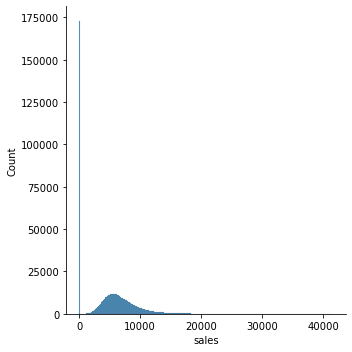

In [25]:
sns.displot(df1['sales'])

In [26]:
#Como entender ?? EXEMPLOS 
#  COMPETITION DISTANCE 
# skew em 10 = skew muito alta, está deslocada pra esquerda 
# kurtosis gigante 
# significa que tem concentração alta de valores no começo

<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

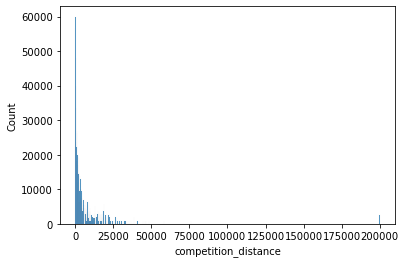

In [27]:
sns.histplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes 

In [28]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

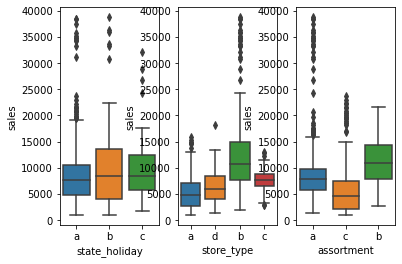

In [29]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 - FEATURE ENGINEERING 

In [30]:
df2 = df1.copy()

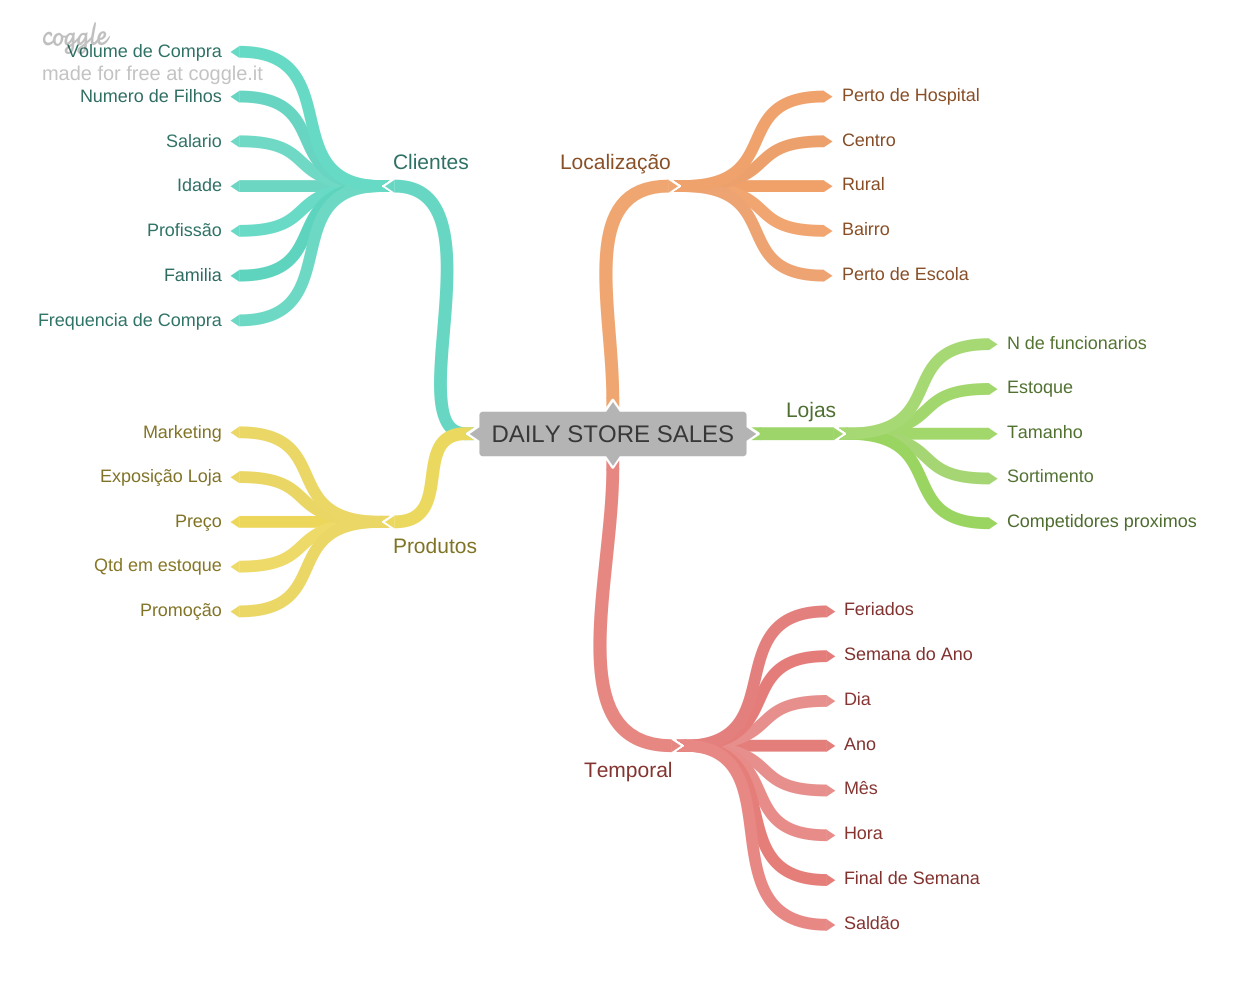

In [31]:
Image('img/MindMapHipoteses.png')

## 2.1 Mapa Mental de Hipoteses

### 2.1.1 Hipoteses da Loja 

**1.** Lojas com maior quadro de funcionários deveriam vender mais. 

**2.** Lojas com maior estoque deveriam vender mais. 

**3.** Lojas com maior porte deveriam vender mais. 

**4.** Lojas com menor porte deveriam vender menos. 

**5.** Lojas com maior sortimento deveriam vender mais. 


### 2.1.2 Hipoteses do Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõe mais o produto nas vitrines deveriam vender mais. 

**3.** Lojas que tem preços menores nos produtos deveriam vender mais. 

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

### 2.1.3 Hipoteses Tempo

**1.** Lojas que tem mais feriados deveriam vender menos. 

**2.** Lojas que abrem nos primeiros seis meses deveriam vender mais. 

**3.** Lojas que abrem nos finais de semana deveriam vender mais. 

## 2.2 Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais. 

**2.** Lojas com competidores mais próximos deveriam vender menos 

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais. 

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.


**12.** Lojas deveriam vender menos durante os feriados escolares 

## 2.3 Feature Engineering

In [32]:
#Variaveis que vamos derivar 

#year 
df2['year'] = df2['date'].dt.year

#month 
df2['month'] = df2['date'].dt.month

#day 
df2['day'] = df2['date'].dt.day
    
#week of year 
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week 
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [33]:
#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)



In [34]:
#promo since 
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


In [35]:
#assortment 
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')


In [36]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variáveis

In [37]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas 

In [38]:
# customers mostra se a loja esta aberta ou fechada, sales tem que ser maior que zero  
df3 = df3[(df3['open'] !=0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas  

In [39]:
#excluiu open porque sabemos que só tem o valor 1, entao nao é relevante 
#promo_interval e month_map porque ja usamos ela para fazer a derivação 
cols_drop = ['customers', 'open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1) 


In [40]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória dos Dados 

In [41]:
df4 = df3.copy()

## 4.1 Análise Univariada

In [42]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 25
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 4.1.1 Response Variable

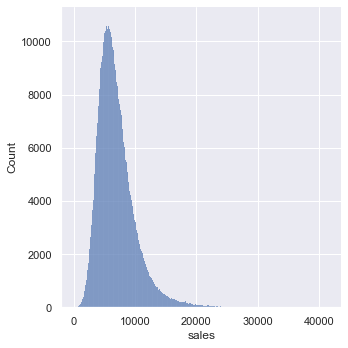

In [43]:
sns.displot(df4['sales'])

### 4.1.2 Numerical Variable

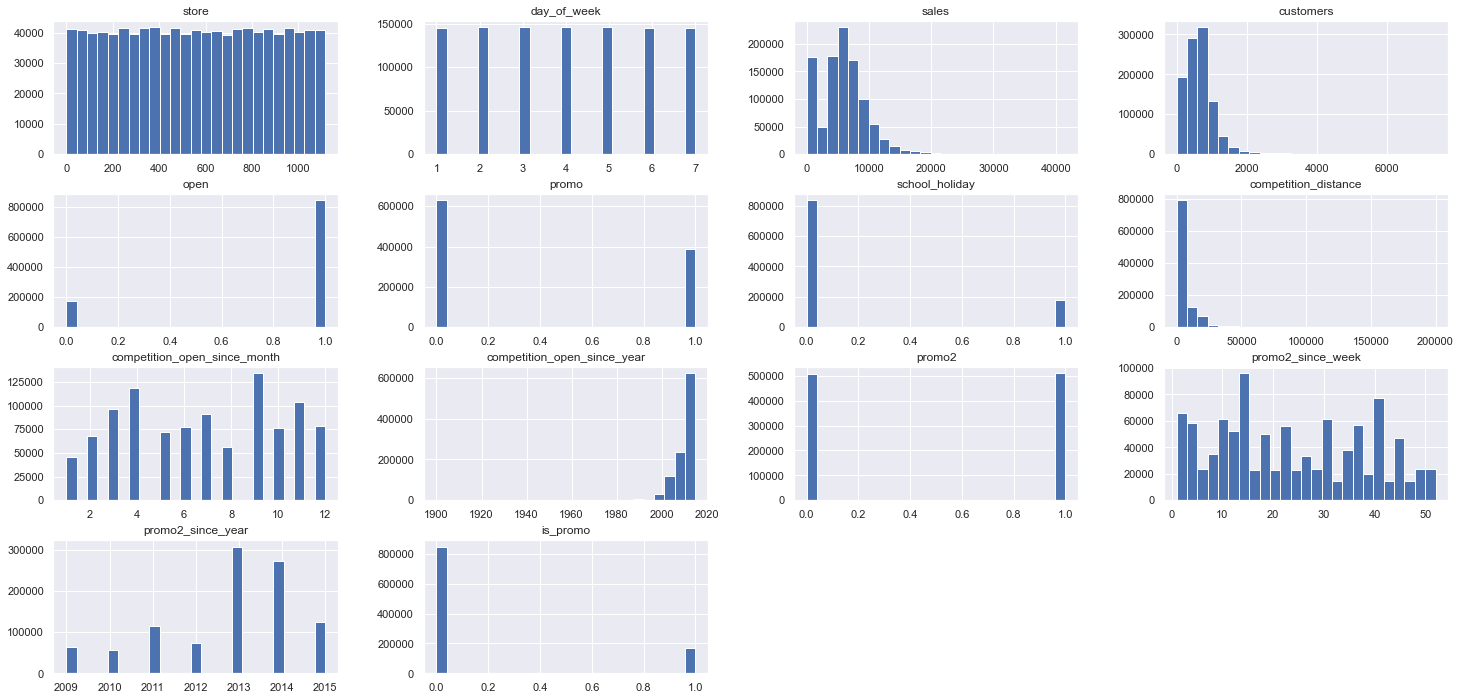

In [44]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [45]:
df4['state_holiday'].drop_duplicates()
df4['store_type'].drop_duplicates()
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\gabri\anaconda3\envs\DSRossmann\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\gabri\anaconda3\envs\DSRossmann\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\gabri\anaconda3\envs\DSRossmann\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='sales', ylabel='Density'>

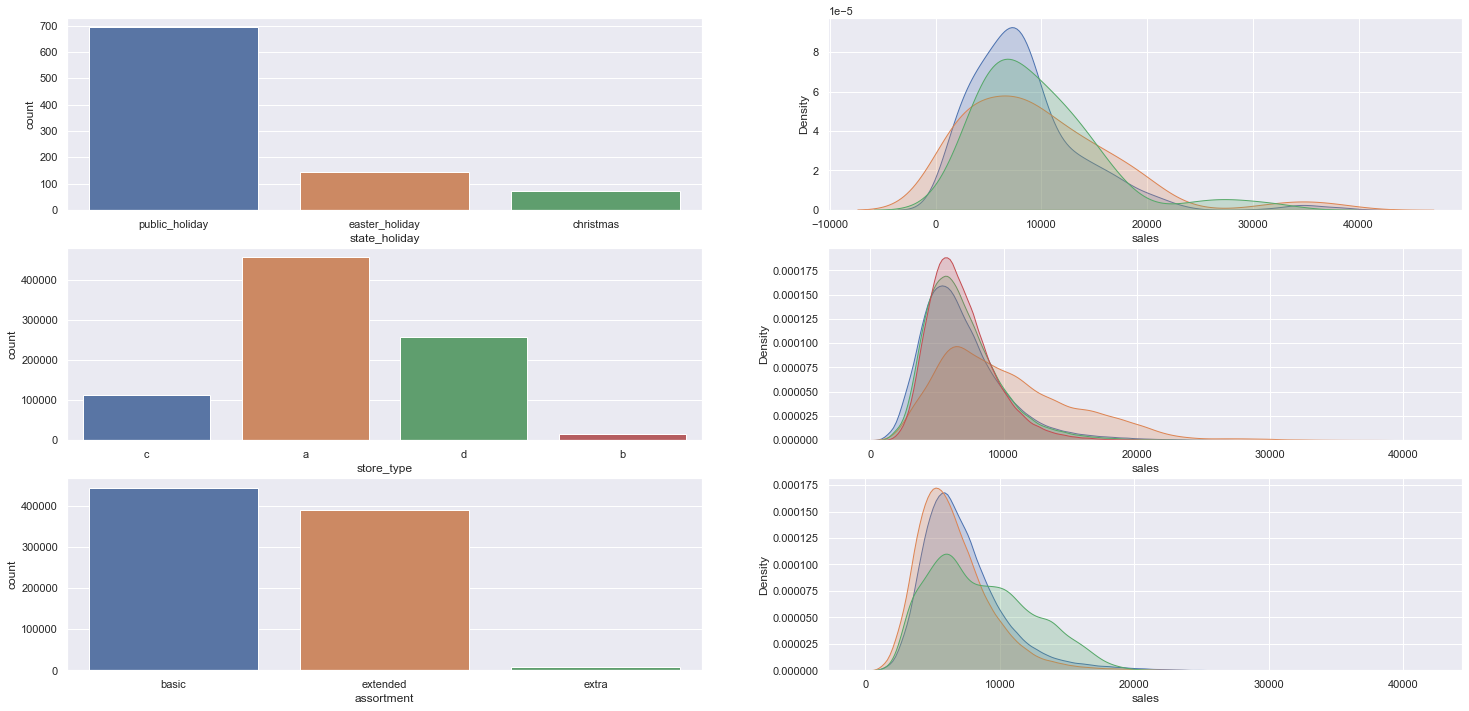

In [46]:
#state_holiday 
# lá no gráfico = primeiro grafico é VOLUME DE VENDAS, segundo grafico é PICO DE VENDAS 
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']) 

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label='Public Holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='Easter Holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label='Christmas', shade=True)


#store_type 
plt.subplot(3,2,3)
sns.countplot(df4['store_type']) 

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label='A', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label='B', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label='C', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label='D', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']) 

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],label='Basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],label='Extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],label='Extra', shade=True)


## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais. 
**Verdadeira**

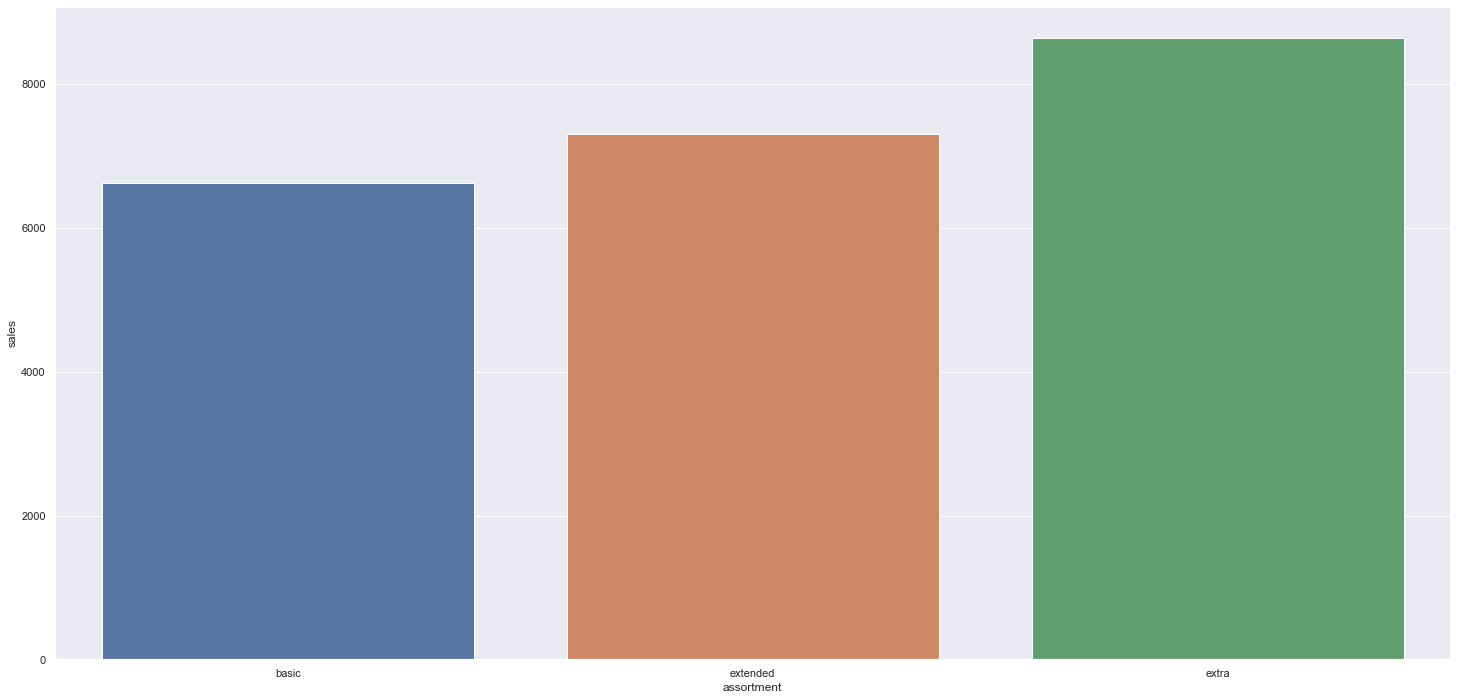

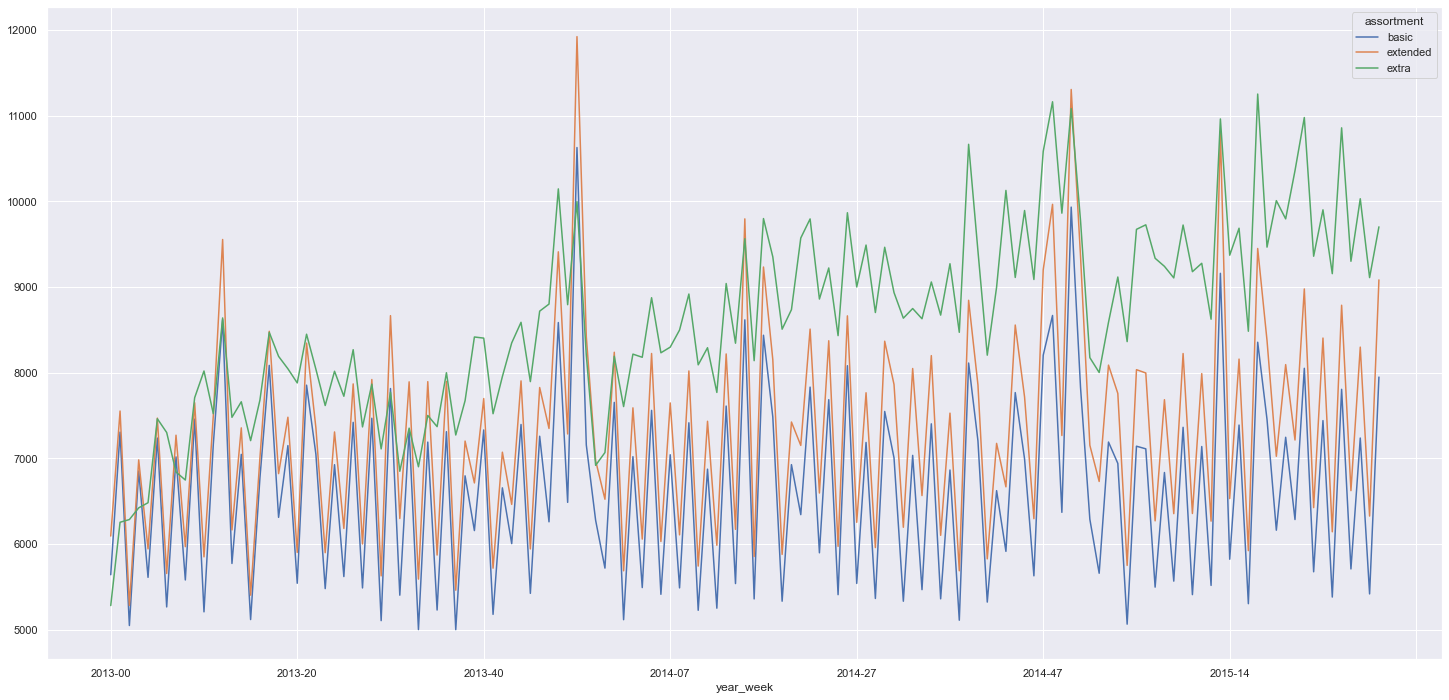

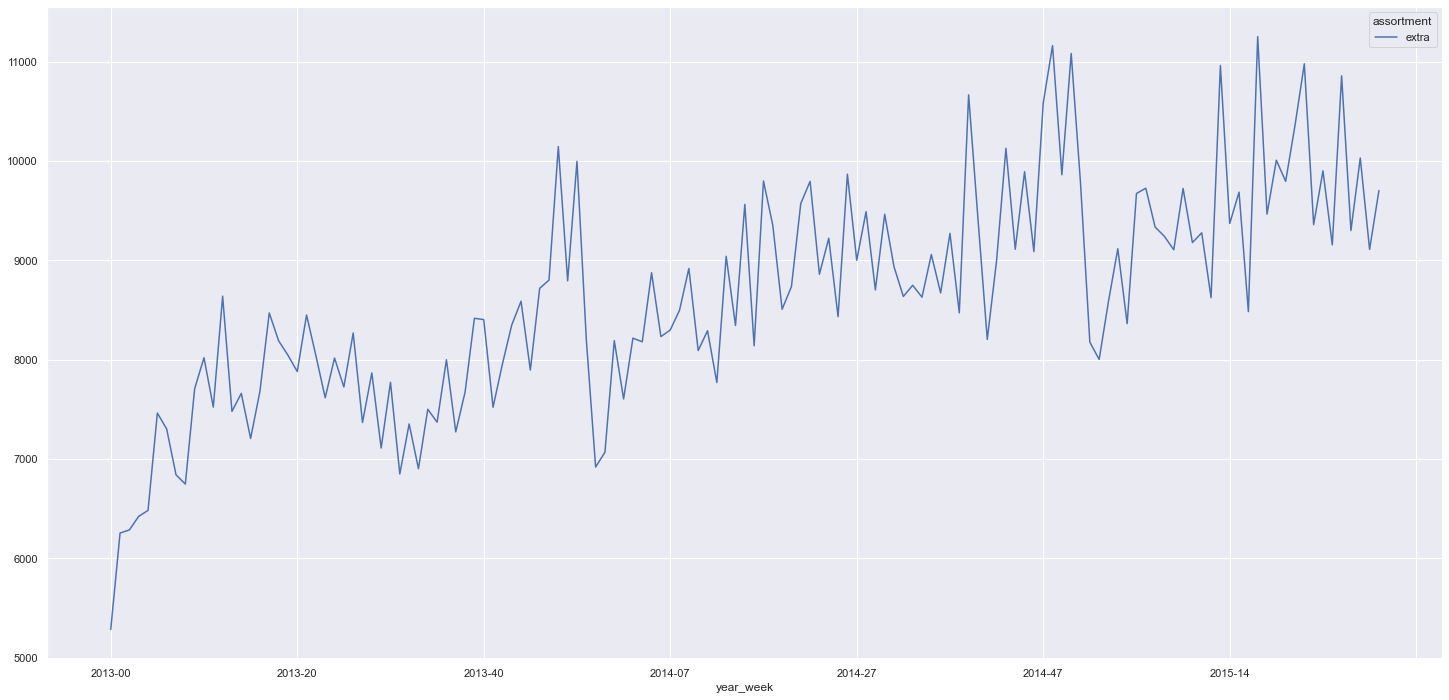

In [47]:
aux1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales',data=aux1); 

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos 
**FALSA** 

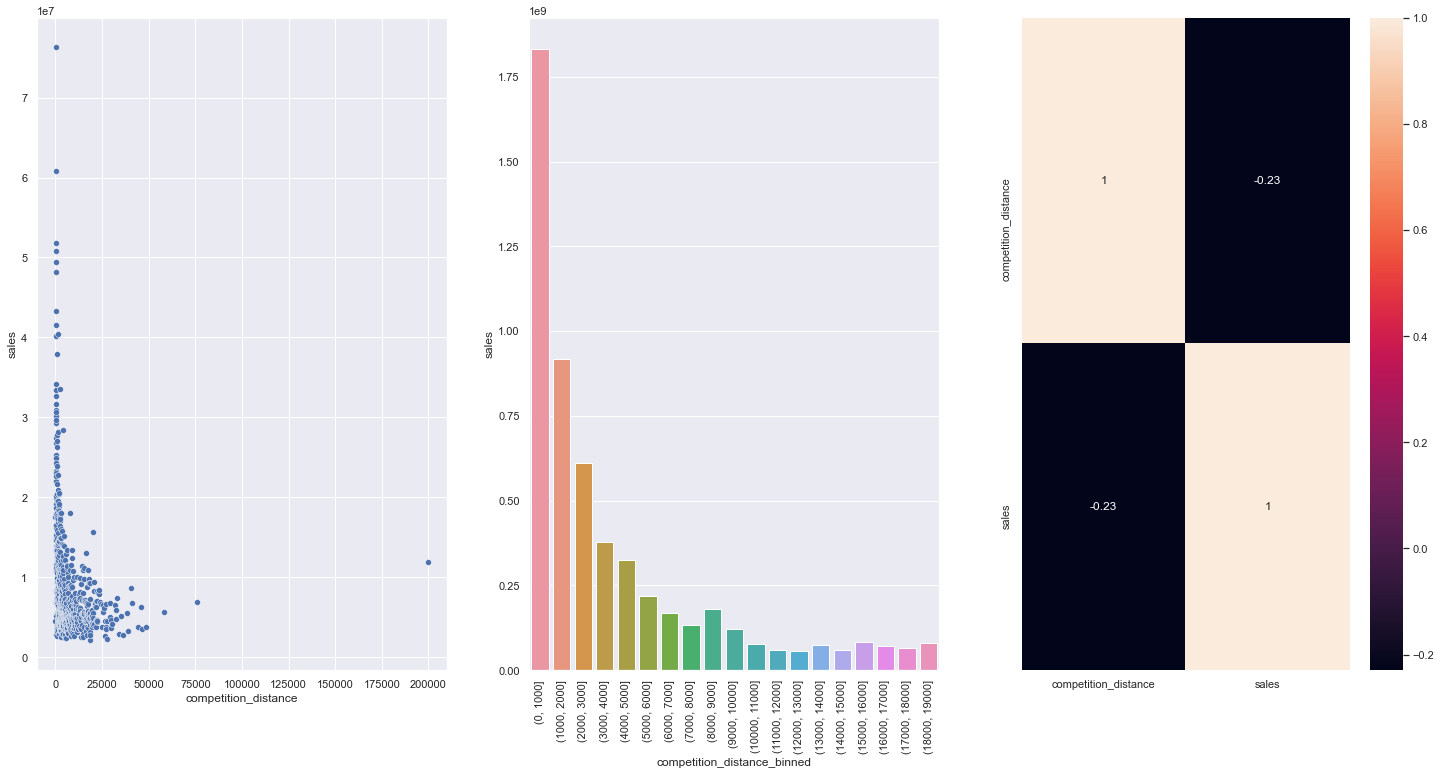

In [48]:
#Isso abaixo é CHOCAR UMA CRENÇA
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index() 

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1); 

plt.subplot(1,3,2)
#como esse grafico vai ficar granulado, vamos criar grupos abaixo 
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index() 
sns.barplot(x='competition_distance_binned', y='sales', data=aux2); 
plt.xticks(rotation=90); 

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'),annot=True);


### **H3.** Lojas com competidores a mais tempo deveriam vender mais. 
**FALSA**

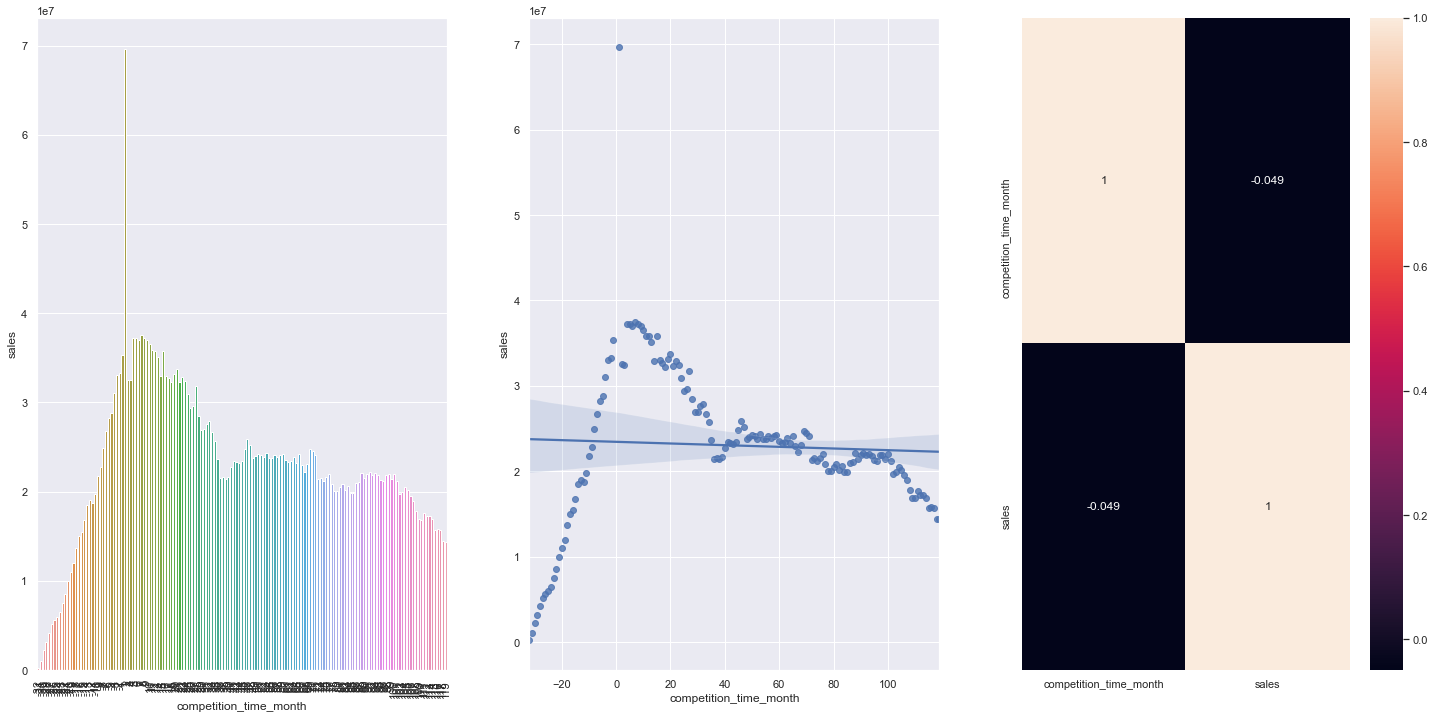

In [49]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)] #pegando os primeiros 120 meses / todos os competidores != 0 = abriu no mesmo mes da venda
sns.barplot(x='competition_time_month',y='sales', data=aux2);
plt.xticks(rotation=90); 

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales', data=aux2); 

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);


## **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais. 

**FALSA** A medida que o tempo passa, as vendas começam a decair. Ou seja, nao se pode manter uma promoção por muito tempo

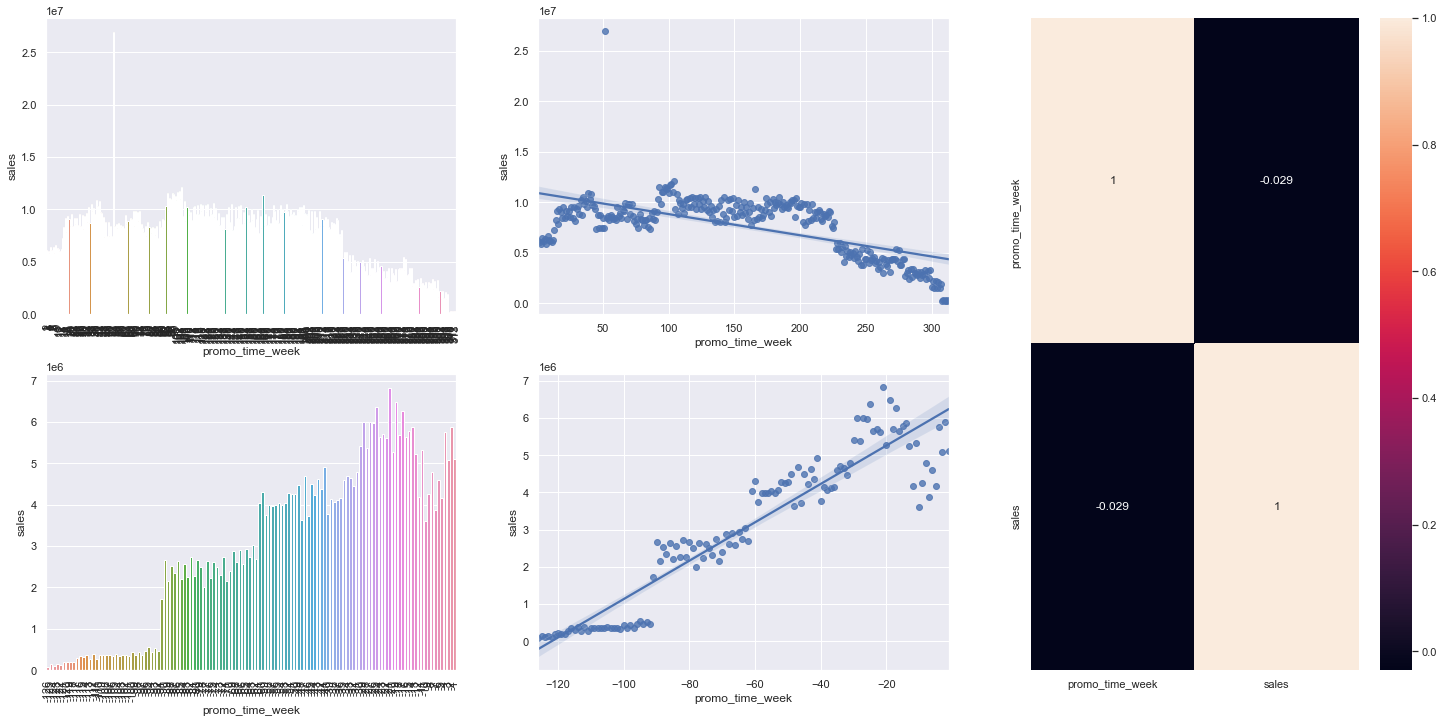

In [50]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week', y='sales', data=aux1); 

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2); 
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2); 

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3); 
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3); 

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

## <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

## **H6.** Lojas com mais promoções consecutivas deveriam vender mais. 
**FALSA**

In [51]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


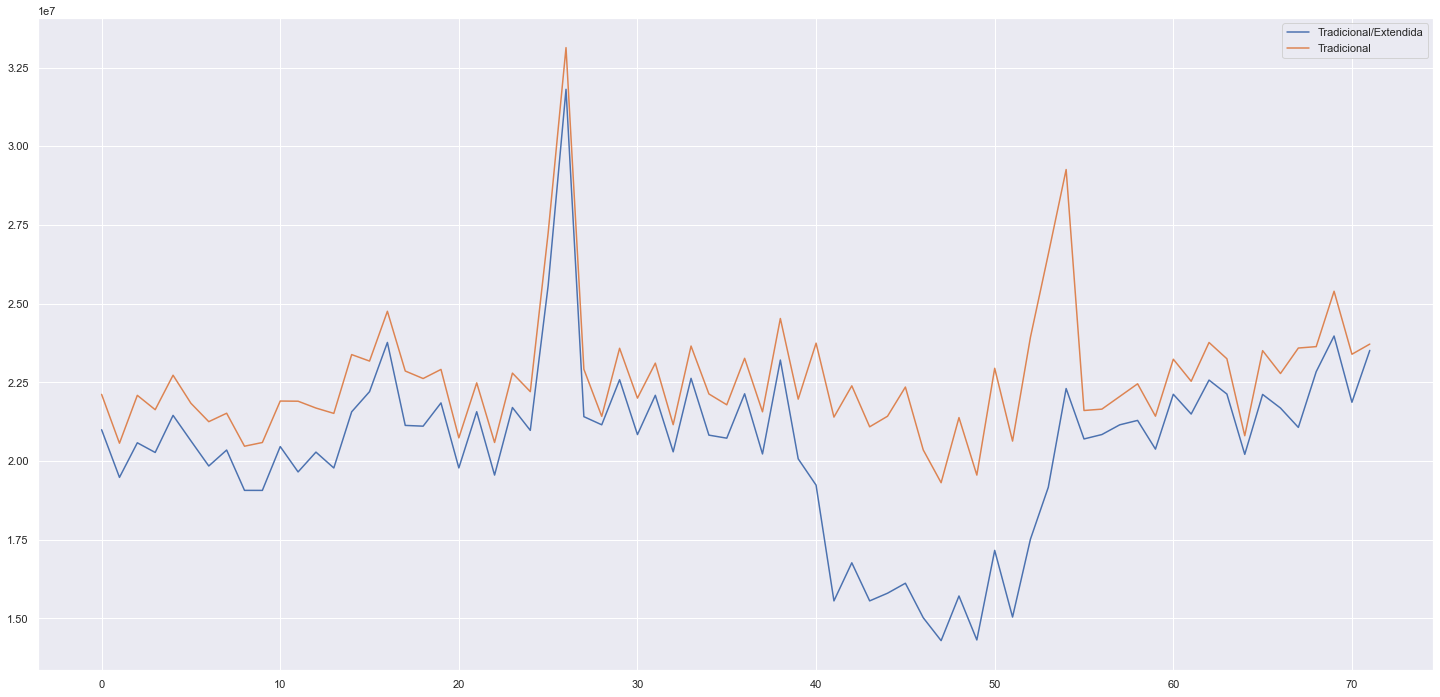

In [52]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] ==1)][['year_week','sales']].groupby('year_week').sum().reset_index() #tradicional e extendido
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] ==0)][['year_week','sales']].groupby('year_week').sum().reset_index() #tradicional
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional/Extendida', 'Tradicional']);

## **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais. 
**FALSA**

<AxesSubplot:xlabel='year', ylabel='sales'>

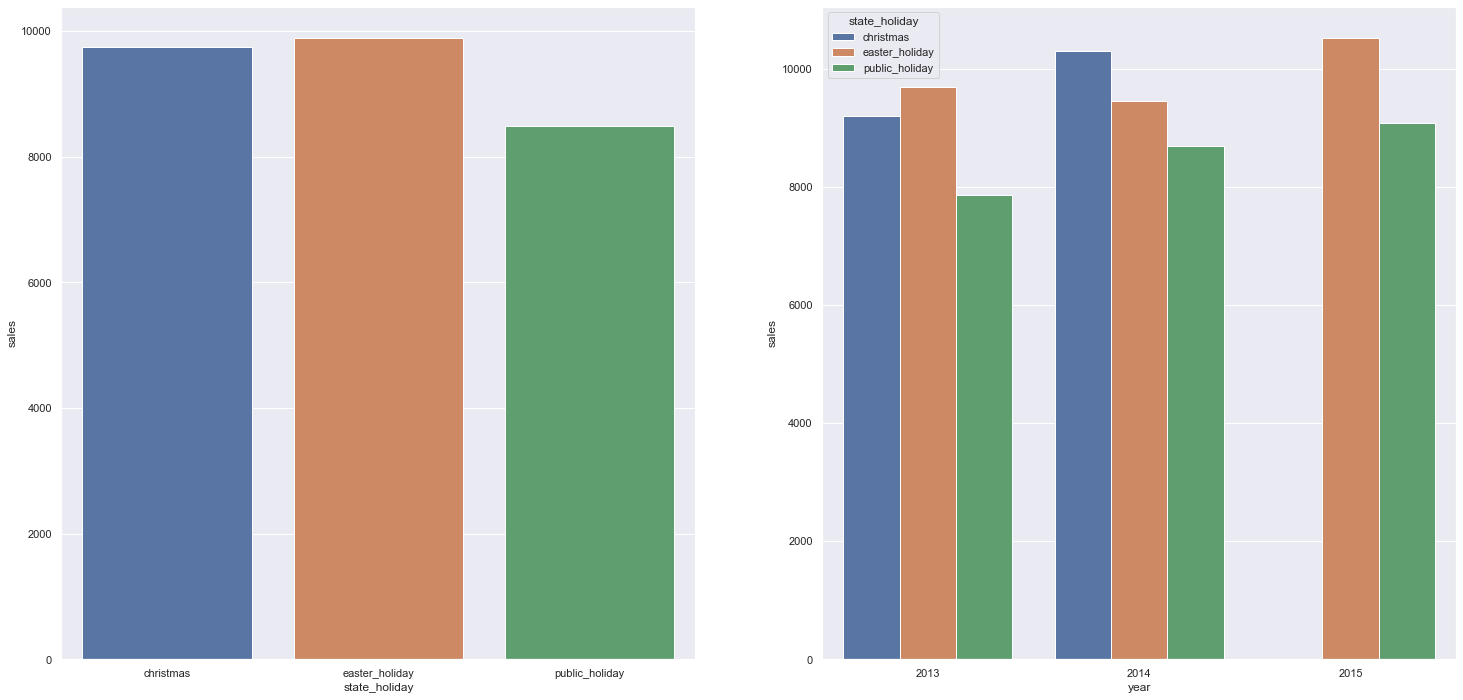

In [56]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales',data=aux1); 

#VERIFICANDO A QNTDE DE VENDE NO FERIADO AO LONGO DO TEMPO 
plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales',hue='state_holiday', data=aux2)


## **H8.** Lojas deveriam vender mais ao longo dos anos. 
**FALSA**

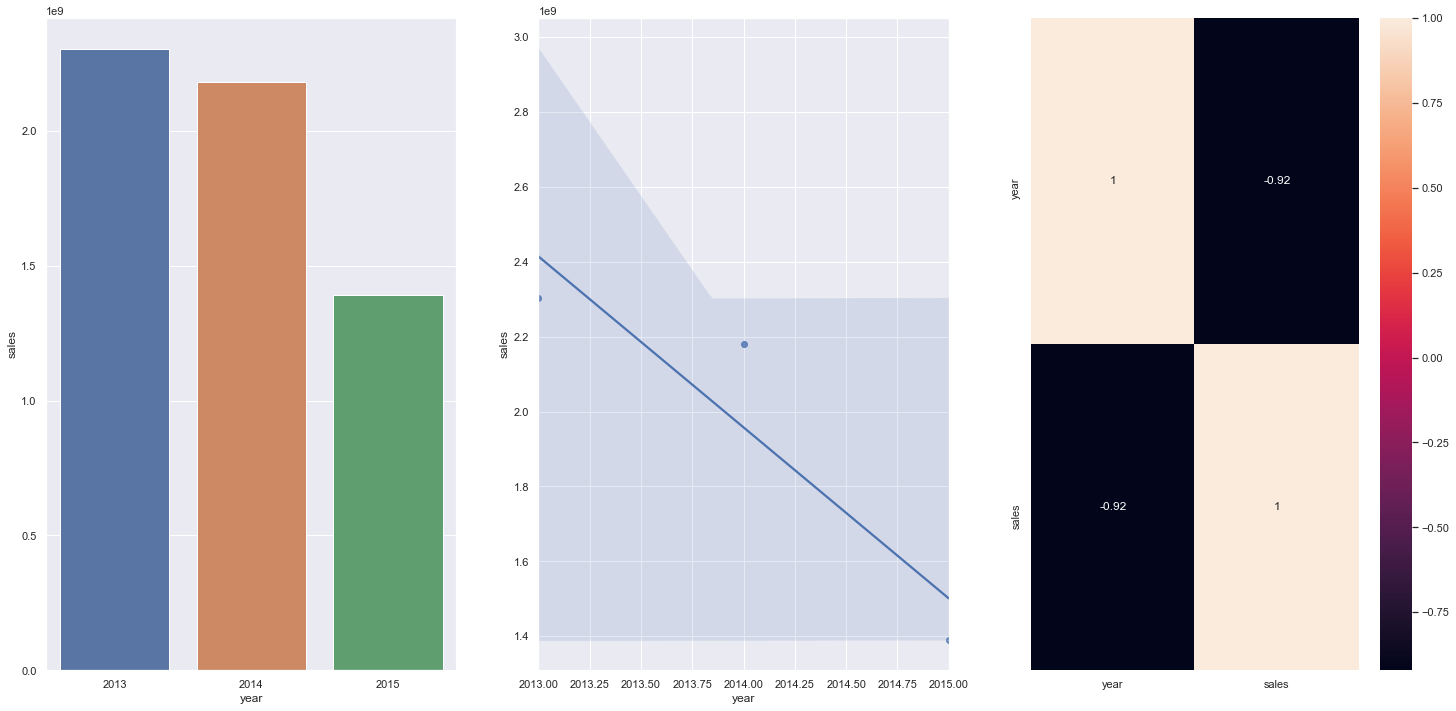

In [60]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales',data=aux1); 

#olhando tendencia e correlação 
plt.subplot(1,3,2)
sns.regplot(x='year', y='sales',data=aux1); 

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True); 



## **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA**

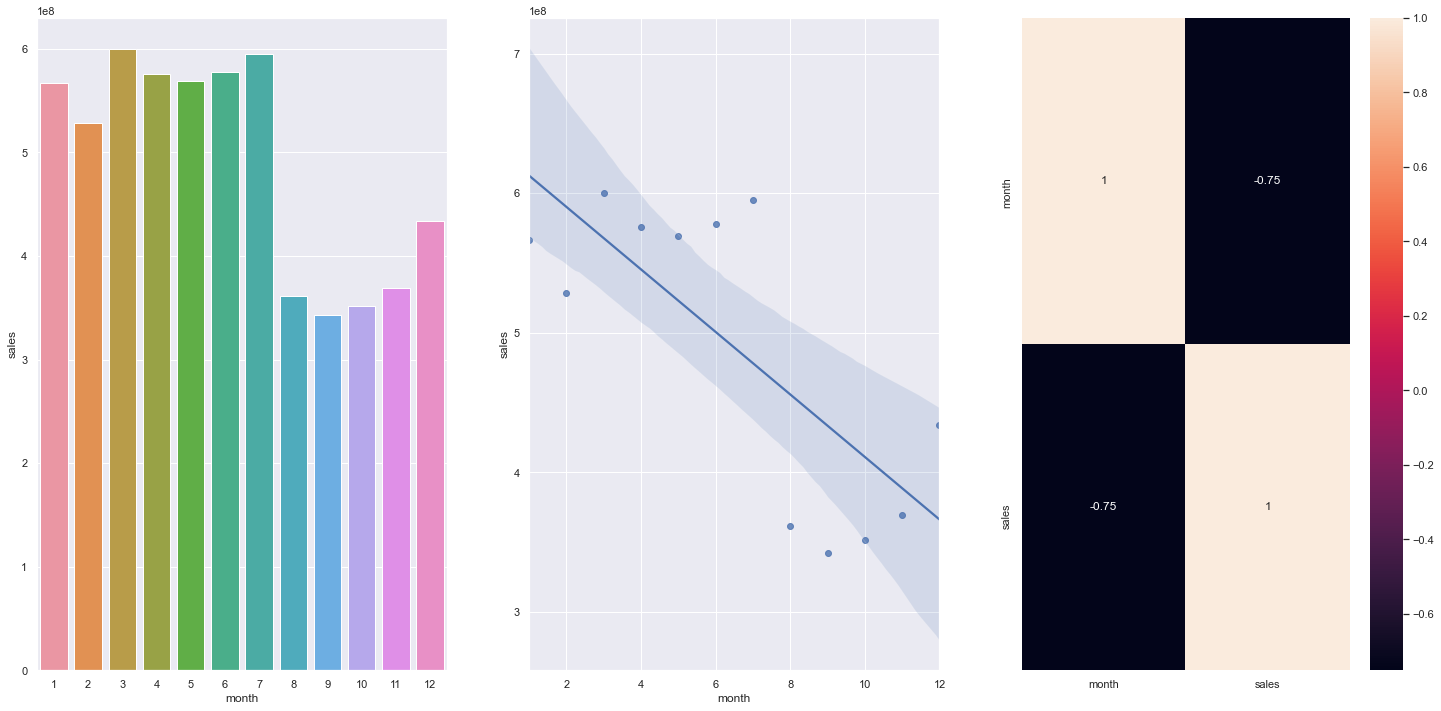

In [61]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales',data=aux1); 

#olhando tendencia e correlação 
plt.subplot(1,3,2)
sns.regplot(x='month', y='sales',data=aux1); 

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True); 



## **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA**

In [68]:
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<= 10 else 'after_10_days')
aux1.head(15)

,day,sales,before_after
0,1,155983560,before_10_days
1,2,233513169,before_10_days
2,3,194582812,before_10_days
3,4,228301010,before_10_days
4,5,212869176,before_10_days
5,6,197094539,before_10_days
6,7,201380487,before_10_days
7,8,189718770,before_10_days
8,9,175922427,before_10_days
9,10,181039363,before_10_days


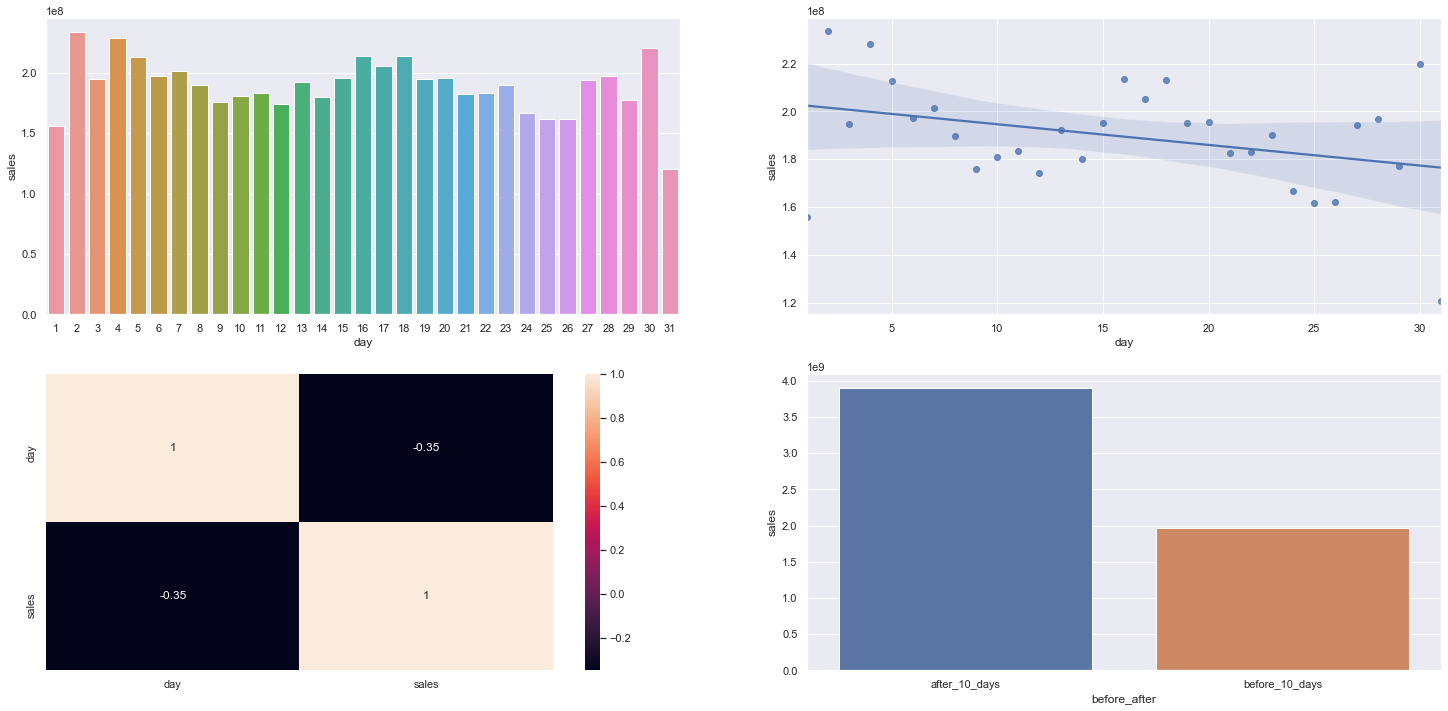

In [70]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales',data=aux1); 

#olhando tendencia e correlação 
plt.subplot(2,2,2)
sns.regplot(x='day', y='sales',data=aux1); 

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True); 

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);



## **H11.** Lojas deveriam vender menos aos finais de semana.

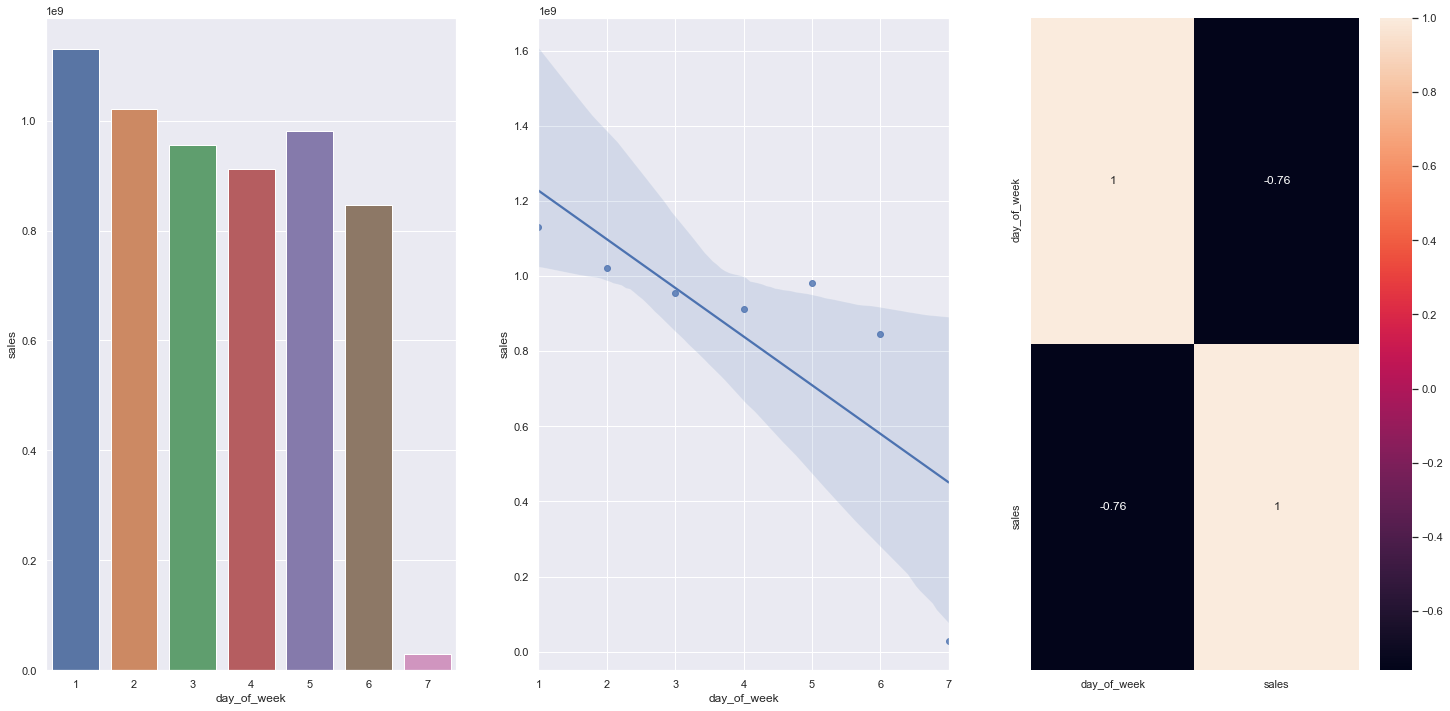

In [72]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales',data=aux1); 

#olhando tendencia e correlação 
plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales',data=aux1); 

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True); 



## **H12.** Lojas deveriam vender menos durante os feriados escolares 
**VERDADEIRA** exceto nos meses 7 e 8 em que as vendas se equiparam 


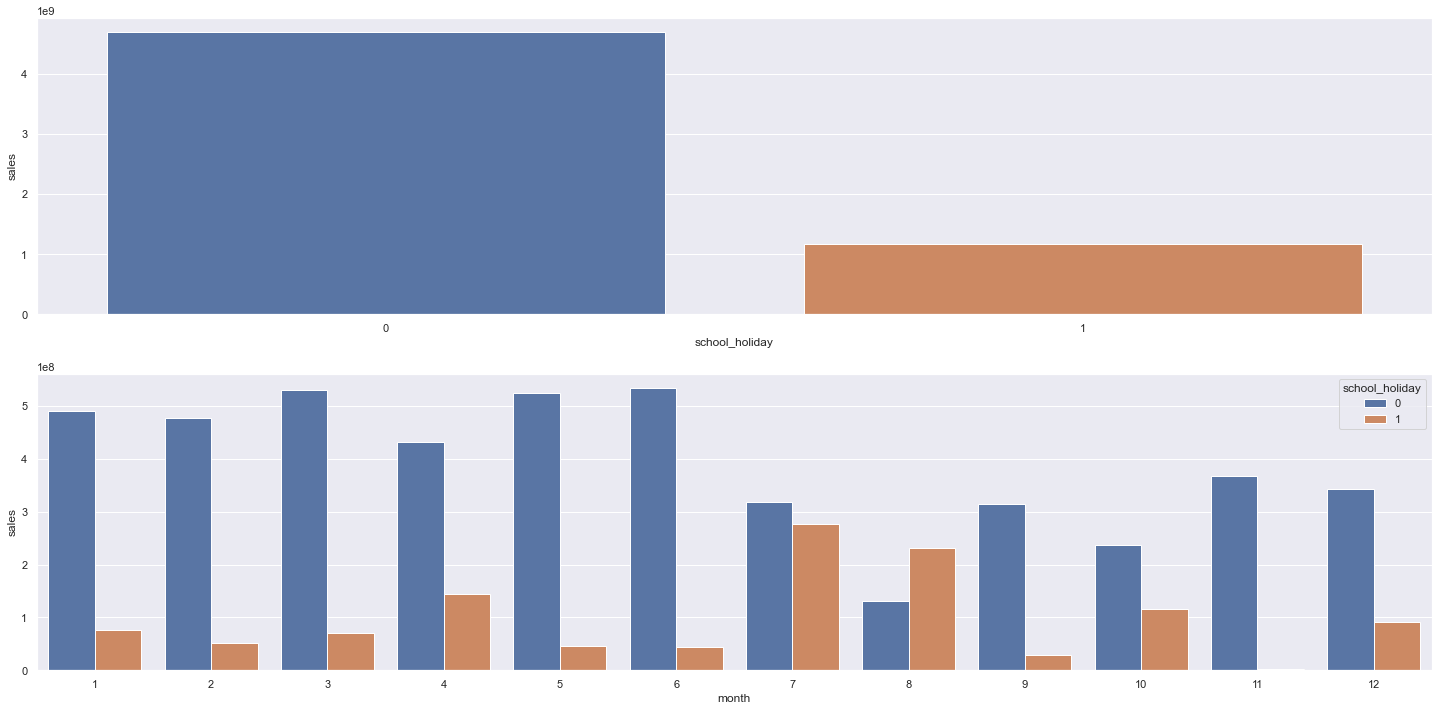

In [77]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales',data=aux1); 

#verificando se tem algum dia que se equipara
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday', data=aux2);

## 4.1 Análise Univariada

## 4.3 Análise Multivariada

In [47]:
## 4.1 Análise Univariada